<a href="https://colab.research.google.com/github/prinzessinmarlenifee/SenseCap/blob/main/SenseCap_v4-2_dataaugment_global_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Global Model with Data Augmentation

##short overview



Saving model and checkpoints for Zwischenspeicherung

CSV-sensor data sheet
1.   wrist
2.   seat
3.  head
-> 3 Sensoren, 9 Spalten
-> checkt erste und zweite Zeile für header (da unterschiedlich)

*   hot encoding for labeling
 Action, Pedaling, Resting, Pushing

 Summary at end with


*   test accuracy
*   confusion matrix

-> saved and stored in Drive as csv and png file





all data is stored in Drive

##Model Choice


✅ Is CNN + LSTM a good choice for IMU-data?


🔎 Why CNN?

    local pattern recognition in short timeframes

    saves time (less parameters than a normal LSTM)

🔁 Why LSTM?

    recognisez time dependencies

    Ideal for sequential datasets

✅ Alternatives or extensions for more performance:

    Bidirectional LSTM → better for symmetrical movements

    Residual CNN Blocks → for deep networks

    Transformer → for big datasets and long sequences

##Setup und Vorbereitung

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Trouble-shooting google drive

In [2]:
import os
if os.path.ismount('/content/drive'):
    print("Drive ist schon gemountet – wird entmountet.")


drive.mount('/content/drive')


Drive ist schon gemountet – wird entmountet.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Packeages and setup

In [3]:
#import packages
import os
import json
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models


In [4]:
# --- PARAMETER ---
sampling_rate = 60       # 60 Hz (SDI-algorythm)
window_size = 60         # 1 second = 60 Frames
step_size = 30           # 50% overlapping

# location for all Sessions
base_dir = '/content/drive/MyDrive/ML-MTB-Modell/IMU-Sessions/'


#Sessions einlesen

In [5]:
#prints founded sessions below
session_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])
print(f"Gefundene Sessions: {len(session_dirs)} -> {session_dirs}")


Gefundene Sessions: 12 -> ['Session_01', 'Session_02', 'Session_03', 'Session_05', 'Session_06', 'Session_07', 'Session_09', 'Session_10', 'Session_11', 'Session_12', 'Session_13', 'Session_14']


Fuktionen zum LAbel-Parsing und Datei finden

In [6]:
# 5.1 parse_hot_labels: reads the _hot.json-file, gives every frame a label
def parse_hot_labels(json_path, total_frames):
    with open(json_path, 'r') as f:
        data = json.load(f)
    entries = data['button_presses'].strip().split(';')

    label_changes = []
    for entry in entries:
        if ':' in entry:
            label, frame = entry.strip().split(':')
            label = label.strip()
            # corrects spelling mistake: "Peadling" → "Pedaling"
            if label.lower() == 'peadling':
                label = 'Pedaling'
            label_changes.append((int(frame.strip()), label))

    frame_labels = ['Unknown'] * total_frames
    for i, (start_frame, label) in enumerate(label_changes):
        end_frame = label_changes[i + 1][0] if i + 1 < len(label_changes) else total_frames
        for f in range(start_frame, min(end_frame, total_frames)):
            frame_labels[f] = label
    return frame_labels

# 5.2 find_sensor_file: finds CSV-Datei, which starts with (Head_, Wrist_, Seat_)
def find_sensor_file(folder, prefix):
    for f in os.listdir(folder):
        if f.lower().startswith(prefix.lower()):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Prefix '{prefix}' in {folder} gefunden.")

# 5.3 find_hot_file: finds JSON-Datei, which ends with "_hot.json"
def find_hot_file(folder):
    for f in os.listdir(folder):
        if f.lower().endswith('_hot.json'):
            return os.path.join(folder, f)
    raise FileNotFoundError(f"❌ Keine Datei mit Suffix '_hot.json' in {folder} gefunden.")


# 6. Fensterung für drei Sensoren kombinieren

In [7]:
def window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels):
    X_windows, y_windows = [], []
    total_frames = len(frame_labels)

    # Assumption: head_data, wrist_data, seat_data all have the same amount of frames = total_frames
    for start in range(0, total_frames - window_size + 1, step_size):
        end = start + window_size

        win_h = head_data[start:end]    # (window_size, 6)
        win_w = wrist_data[start:end]
        win_s = seat_data[start:end]
        window = np.concatenate([win_h, win_w, win_s], axis=1)  # → (window_size, 18)

        label_window = frame_labels[start:end]
        dominant_label = Counter(label_window).most_common(1)[0][0]
        if dominant_label == 'Unknown':
            continue

        X_windows.append(window)
        y_windows.append(dominant_label)

    return np.array(X_windows), np.array(y_windows)


#7. Daten einlesen und Fenster / Labels erzeugen
→ Nach Ausführung siehst du für jede Session etwa: “→ 153 Fenster, 3 Klassen” etc.

In [8]:
#Preperation
sessions_X = []
sessions_y = []
valid_sessions = []  # <- new List (valid sessions only)
skipped_sessions = []

#defining features:
features = ['Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']


def smart_feature_filter(df):
    # comparing all lowercase
    keep = [col for col in df.columns if any(kw in col.lower() for kw in ['euler', 'acc', 'gyr'])]
    return df[keep]

def print_csv_headers(path, label):
    with open(path, 'r') as f:
        lines = f.readlines()
    print(f"\n📋 {label} → Datei: {os.path.basename(path)}")
    print("   Zeile 0:", lines[0].strip())
    print("   Zeile 1:", lines[1].strip())


def inspect_sensor_csv(path):
    df = pd.read_csv(path, sep=',', skiprows=1)
    df.columns = df.columns.str.strip()
    print(f"📊 {os.path.basename(path)}: {df.shape[1]} Spalten")
    print("   → Spaltennamen:", df.columns.tolist())




def load_sensor_csv(path):
  import csv

  # reading first two rows
  with open(path, 'r') as f:
      reader = csv.reader(f)
      first_line = next(reader)
      second_line = next(reader)

  # checking if first row is a header (with nown keywords for example)
  first_line_str = ",".join(first_line).lower()
  if any(kw in first_line_str for kw in ['euler', 'acc', 'gyr']):
      skip = 0
  else:
      skip = 1

  # reading
  df = pd.read_csv(path, sep=',', skiprows=skip)
  df.columns = df.columns.str.strip()

  # filtering features
  df = smart_feature_filter(df)

  # numerical transformation
  df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

  return df.values

  print(f"🔍 {os.path.basename(path)}: Header {'erste Zeile' if skip==0 else 'zweite Zeile'}")




# Main loop
for sess_dir in session_dirs:
    print(f"\n📂 Lade Session: {sess_dir}")
    session_path = os.path.join(base_dir, sess_dir)


    # 7.1 find sensor-data
    head_path  = find_sensor_file(session_path, 'Head_')
    wrist_path = find_sensor_file(session_path, 'Wrist_')
    seat_path  = find_sensor_file(session_path, 'Seat_')

    # 7.2 find Hot-JSON-files
    hot_path = find_hot_file(session_path)

    inspect_sensor_csv(head_path)
    inspect_sensor_csv(wrist_path)
    inspect_sensor_csv(seat_path)


    #print csv-heads for debugging & checking (defined function from before print_csv_headers)
    #print_csv_headers(head_path, 'Head')
    #print_csv_headers(wrist_path, 'Wrist')
    #print_csv_headers(seat_path, 'Seat')




    # 7.3 load IMU-data
    #load the function for IMU
    #current problem: header is in the second row, seperator ',' , only finds two rows when reading the file



    head_data  = load_sensor_csv(head_path)
    wrist_data = load_sensor_csv(wrist_path)
    seat_data  = load_sensor_csv(seat_path)




    print(f"📊 Sensorlängen: Head={head_data.shape}, Wrist={wrist_data.shape}, Seat={seat_data.shape}")

    #expected_features = 27  # 3 Sensoren × 9 Features (already defined)
   # if X_win.shape[1:] != (window_size, expected_features):
    #      print(f"⚠️ Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
     #     skipped_sessions.append(sess_dir)
      #    continue



    #7.4 load Labels
    total_frames = min(head_data.shape[0], wrist_data.shape[0], seat_data.shape[0])
    frame_labels = parse_hot_labels(hot_path, total_frames)



    # 7.5 shortening
    head_data  = head_data[:total_frames]
    wrist_data = wrist_data[:total_frames]
    seat_data  = seat_data[:total_frames]
    frame_labels = frame_labels[:total_frames]


    # 7.6 windowing & assigning labels
    X_win, y_win = window_data_multiple_sensors(head_data, wrist_data, seat_data, frame_labels)

    # 5. check validity
    if len(X_win) == 0:
        print(f"⚠️  Session {sess_dir} übersprungen – keine gültigen Fenster.")
        skipped_sessions.append(sess_dir)
        continue

    expected_features = 27

    if X_win.shape[1:] != (window_size, expected_features):
        print(f"⚠️  Session {sess_dir} hat Format {X_win.shape[1:]}, wird übersprungen.")
        skipped_sessions.append(sess_dir)
        continue


        # 6. save
    sessions_X.append(X_win)
    sessions_y.append(y_win)
    valid_sessions.append(sess_dir)
    print(f"✅ Session {sess_dir}: {len(X_win)} Fenster, {len(np.unique(y_win))} Klassen")

# --- summarization ---
print("\n✅ Verwendete Sessions:")
for idx, sess in enumerate(valid_sessions):
    print(f"  {sess}: {sessions_X[idx].shape}")

if skipped_sessions:
    print("\n⛔️ Übersprungene Sessions:")
    for s in skipped_sessions:
        print(f"  {s}")











📂 Lade Session: Session_01
📊 Head_D422CD00563B_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Wrist_D422CD004550_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Seat_D422CD00456D_20230713_082527.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']
📊 Sensorlängen: Head=(60077, 9), Wrist=(60078, 9), Seat=(60075, 9)
✅ Session Session_01: 1997 Fenster, 3 Klassen

📂 Lade Session: Session_02
📊 Head_D422CD00563B_20230713_085629.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed:

/tmp/ipython-input-8-667840779.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Wrist_D422CD004550_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-8-667840779.py:25: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=1)


📊 Seat_D422CD00456D_20230727_073528.csv: 12 Spalten
   → Spaltennamen: ['PacketCounter', 'SampleTimeFine', 'Euler_X', 'Euler_Y', 'Euler_Z', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Unnamed: 11']


/tmp/ipython-input-8-667840779.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)
/tmp/ipython-input-8-667840779.py:50: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',', skiprows=skip)


📊 Sensorlängen: Head=(65763, 9), Wrist=(65763, 9), Seat=(65763, 9)
✅ Session Session_11: 2181 Fenster, 4 Klassen

📂 Lade Session: Session_12
📊 Head_D422CD004576_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '416010770', '-4.522172451019287', '48.04213333129883', '21.0351619720459', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Wrist_D422CD004550_20230801_075834.csv: 12 Spalten
   → Spaltennamen: ['0', '532295258', '-42.42717361450195', '45.996009826660156', '-55.192440032958984', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '']
📊 Seat_D422CD00456D_20230801_075834.csv: 11 Spalten
   → Spaltennamen: ['0', '409881162', '2202328491210930', '-6035955047607420', '-8357672119140620', '0.00000000000000', '0.00000000000000.1', '0.00000000000000.2', '0.00000000000000.3', '0.00000000000000.4', '0.00000000000000.5']
📊 Sensorlängen: Head=(59523, 9), Wrist=(59524, 9), Seat=(59514, 9)
✅ Session Session_12: 1967 Fenster, 4 Klassen

📂 Lade Session: Session_13
📊 Head_D422CD004576_20230802_080027.c

🧠 Dann ist deine Fensterform:

    3 Sensoren × 9 Spalten = 27 Features
    → Fenster-Shape: (window_size, 27) = (60, 27)


Euler_X, Euler_Y, Euler_Z


Acc_X, Acc_Y, Acc_Z

Gyr_X, Gyr_Y, Gyr_Z

→ = 9 physikalisch sinnvolle Spalten pro Sensor

#8. Global Model: Training and Evaluation




explanation step after step

  **1. merge data**

    all sessions are merged into one dataset so that the model can learn from it

 **2. Label-Encoding**


    the model only works with numbers. The labels (different activities) are transformed into numbers.

 **3. Training- and validation-split**

    The dataset will be split into training (90%) and validation (10%) so the model can be validated while it is being trained.

  **4. creating the model**
  
    The model combines convolutional layers (to recognize lokal patterns) with LSTM (to learn dependencies over time). Dropout is being used to prevent overfitting.

  **5. Checkpoint Callback**

    During training, models will be saved after every epoch (only the best ones after validity-check)

  **6. Training**
  
    The modell learns over 50 epochs. Training and validation-data is being used.

  **7. saving the final model**

    The final model is being saved to load and use it later on.

  **8. Evaluation on validity-data**

    The modell is being tested on the validation-data to test its accuracy

  **9.  creating predictions**

    Die Wahrscheinlichkeiten für jede Klasse werden ermittelt und in Klassen umgewandelt (höchste Wahrscheinlichkeit = Vorhersage).
    The probability for each class is being determined. Then it is transformed into classes (highest probability = prediction)

  **10.  checking labels **

    Only the classes from the validation-data are being used for the report

 **11.  Classification Report**

    Precision, recall, F1-score and support are calculated for each class. These are importand measures for the quality of the model.

  **12.  Confusion Matrix**

    visualizes precision and mistakes of the model


[link text](https://)##📘 What is a docstring?



a docstring is a string literal specified in source code that is used, like a comment, to document a specific segment of code.

example:

def addiere(a, b):
    """
    this function adds two number and returns the result.
    
    Parameter:
    a (int): first number
    b (int): second number

    return:
    int: Sum from a and b
    """
    return a + b

* a docstring is used in the following way:

help(addiere)

* 📋 result:

  Help on function addiere in module __main__:


   
    

In [9]:
# this codecell is used to check how balanced the dataset is

label_counts = Counter(y_win)
print("\n📋 Summary of Labels in the last processed session:")
for label, count in label_counts.items():
    print(f"  {label}: {count} sections")

# To get the total count across ALL valid sessions:
all_labels = [label for session_labels in sessions_y for label in session_labels]
total_label_counts = Counter(all_labels)

print("\n📋 Total Summary of Labels across ALL valid sessions:")
for label, count in total_label_counts.items():
    print(f"  {label}: {count} sections")

# Specifically for the requested labels:
print("\nRequested Label Counts:")
print(f"  Action: {total_label_counts.get('Action', 0)} sections")
print(f"  Resting: {total_label_counts.get('Resting', 0)} sections")
print(f"  Pedaling: {total_label_counts.get('Pedaling', 0)} sections")
# Assuming 'action labeled sections' refers to the 'Action' label
# If it's a distinct label, you'd need to add it to the Counter logic.
# Based on the code, 'Action' seems to be the relevant label.
print(f"  action labeled sections: {total_label_counts.get('Action', 0)} sections")


📋 Summary of Labels in the last processed session:
  Resting: 1165 sections
  Pedaling: 46 sections
  Action: 567 sections
  Pushing: 91 sections

📋 Total Summary of Labels across ALL valid sessions:
  Resting: 12573 sections
  Pedaling: 728 sections
  Action: 7656 sections
  Pushing: 2251 sections

Requested Label Counts:
  Action: 7656 sections
  Resting: 12573 sections
  Pedaling: 728 sections
  action labeled sections: 7656 sections


In [10]:
# this codecell is used to downsample the uneven distributed data. Thats to ensure no overfitting is taking place for specifiv labels

# Separate data by label
data_by_label = {}
for i in range(len(all_labels)):
  label = all_labels[i]
  if label not in data_by_label:
    data_by_label[label] = []
  # Find which session and index the window belongs to
  current_window_idx = 0
  found = False
  for session_idx, session_X in enumerate(sessions_X):
    num_windows_in_session = len(session_X)
    if i >= current_window_idx and i < current_window_idx + num_windows_in_session:
      index_in_session = i - current_window_idx
      data_by_label[label].append((session_X[index_in_session], label))
      found = True
      break
    current_window_idx += num_windows_in_session
  if not found:
      print(f"Warning: Could not find session data for overall index {i} with label {label}")


# Downsample labels (except 'Action')
downsampled_data = []
max_sections = 5000

for label, data in data_by_label.items():
    if label != 'Action' and len(data) > max_sections:
        print(f"Downsampling label '{label}' from {len(data)} to {max_sections} sections.")
        # Randomly sample
        indices = np.random.choice(len(data), max_sections, replace=False)
        downsampled_data.extend([data[i] for i in indices])
    else:
        print(f"Keeping all {len(data)} sections for label '{label}'.")
        downsampled_data.extend(data)

# Shuffle the downsampled data
np.random.shuffle(downsampled_data)

# Separate features (X) and labels (y) from downsampled data
X_combined_downsampled = np.array([item[0] for item in downsampled_data])
y_combined_downsampled = np.array([item[1] for item in downsampled_data])

print(f"\nTotal sections after downsampling: {len(X_combined_downsampled)}")
downsampled_label_counts = Counter(y_combined_downsampled)
print("\n📋 Summary of Labels after downsampling:")
for label, count in downsampled_label_counts.items():
    print(f"  {label}: {count} sections")



Downsampling label 'Resting' from 12573 to 5000 sections.
Keeping all 728 sections for label 'Pedaling'.
Keeping all 7656 sections for label 'Action'.
Keeping all 2251 sections for label 'Pushing'.

Total sections after downsampling: 15635

📋 Summary of Labels after downsampling:
  Action: 7656 sections
  Resting: 5000 sections
  Pushing: 2251 sections
  Pedaling: 728 sections


#Code

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
879/880 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5187 - loss: 1.0851
Epoch 1: val_loss improved from inf to 0.95325, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_01.keras
880/880 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.5188 - loss: 1.0849 - val_accuracy: 0.6074 - val_loss: 0.9532
Epoch 2/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6189 - loss: 0.9211
Epoch 2: val_loss improved from 0.95325 to 0.92058, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_02.keras
880/880 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.6189 - loss: 0.9211 - val_accuracy: 0.6176 - val_loss: 0.9206
Epoch 3/50
879/880 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6400 - loss: 0.8846
Epoch 3: val_loss improved from 0.92058 to 0.88268, saving model to /content/drive/MyDrive/mtb_project/checkpoints_global/global_epoch_03.keras
880/880 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6401 - loss: 0.8

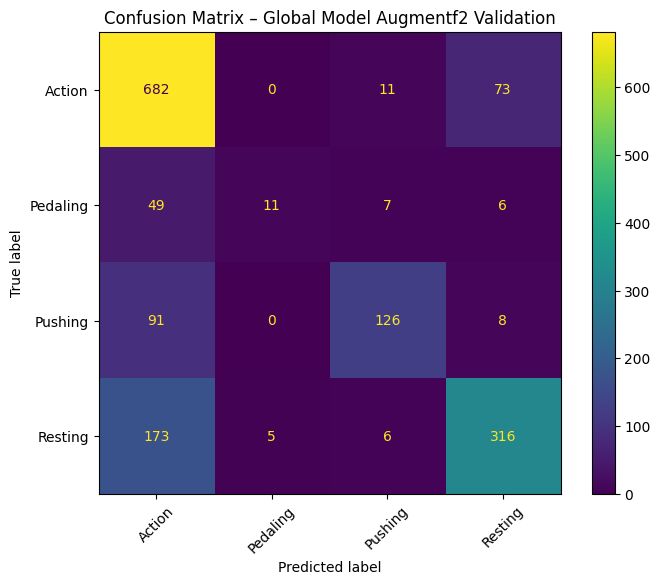

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.multiclass import unique_labels
import random
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# 💾 Speicherpfade anlegen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

#Data Augmentation

def augment_time_series_multiclass(X, y, augment_factor=2, jitter_std=0.02, scale_range=(0.85, 1.15),
                                   permute_segments=3, apply_mixup=False, seed=42):
    """
    Führt Data Augmentation für multiklassige Zeitreihen durch.

    Args:
        X (np.array): Zeitreihendaten (N, T, F)
        y (np.array): Labels (N,)
        augment_factor (int): Wie viele zusätzliche augmentierte Samples pro Original (z. B. 2x = verdreifacht)
        jitter_std (float): Standardabweichung für Jittering (z. B. 0.01)
        scale_range (tuple): Min/Max Faktor für Scaling (z. B. (0.9, 1.1))
        permute_segments (int): Anzahl Segmente für Shuffle (z. B. 3)
        apply_mixup (bool): Ob Mixup verwendet werden soll (optional)
        seed (int): Random-Seed für Reproduzierbarkeit

    Returns:
        X_aug, y_aug: augmentierte Daten
    """
    np.random.seed(seed)
    random.seed(seed)

    N, T, F = X.shape
    X_aug = []
    y_aug = []

    def jitter(x):
        return x + np.random.normal(loc=0., scale=jitter_std, size=x.shape)

    def scale(x):
        factor = np.random.uniform(*scale_range)
        return x * factor

    def permute(x):
        segs = np.array_split(x, permute_segments)
        np.random.shuffle(segs)
        return np.concatenate(segs, axis=0)

    def mixup(x1, x2, y1, y2):
        alpha = np.random.beta(0.4, 0.4)
        x_mix = alpha * x1 + (1 - alpha) * x2
        # Label bleibt einfach y1 oder y2 – einfacher Ansatz
        return x_mix, y1 if np.random.rand() < 0.5 else y2

    for i in range(N):
        for _ in range(augment_factor):
            x_aug = X[i]

            # Transformationen
            if np.random.rand() < 0.5:
                x_aug = jitter(x_aug)
            if np.random.rand() < 0.5:
                x_aug = scale(x_aug)
            if np.random.rand() < 0.3:
                x_aug = permute(x_aug)

            if apply_mixup and np.random.rand() < 0.3:
                idx2 = np.random.randint(0, N)
                x_aug, y_mix = mixup(x_aug, X[idx2], y[i], y[idx2])
                y_aug.append(y_mix)
            else:
                y_aug.append(y[i])

            X_aug.append(x_aug)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    # Zusammenführen
    X_combined = np.concatenate([X, X_aug])
    y_combined = np.concatenate([y, y_aug])

    return X_combined, y_combined




# 1️⃣ Sessions zusammenführen (dieser Teil muss mit deinen Daten ergänzt werden!)
# Beispiel:
X_all = X_combined_downsampled
y_all = y_combined_downsampled

# 2️⃣ Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)


# joblib.dump(le, "/content/drive/MyDrive/mtb_project/label_encoder.pkl") #speicherung der labels für Auswertung später


# 3️⃣ Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4️⃣ Augmentieren – auf Original-Labels
y_train_original = le.inverse_transform(y_train)
X_aug, y_aug = augment_time_series_multiclass(X_train, y_train_original)
y_aug_enc = le.transform(y_aug)

# 🔀 Kombinieren
X_train_combined = np.concatenate([X_train, X_aug])
y_train_combined = np.concatenate([y_train, y_aug_enc])

# 5️⃣ Modell bauen
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(100, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6️⃣ Callback für Checkpoints
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "global_epoch_{epoch:02d}.keras"),
    save_best_only=True, save_weights_only=False, verbose=1
)

# 7️⃣ Training
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=64,
    callbacks=[checkpoint_cb]
)

# 8️⃣ Speichern des finalen Modells
model.save(os.path.join(final_model_dir, "global_final_augment_factor2.keras"))

# 9️⃣ Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n✅ Validation Accuracy: {val_acc:.2f}")

# 🔮 Vorhersagen
y_pred_probs = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 📊 Report + Matrix
labels_present = unique_labels(y_val, y_pred_classes)
report_text = classification_report(
    y_val, y_pred_classes,
    labels=labels_present,
    target_names=[le.classes_[i] for i in labels_present]
)
print("\n📄 Classification Report:\n")
print(report_text)

# 💾 Speichern als Text
with open(os.path.join(report_dir, "global_model_augmentf2_classification_report{timestamp}.txt"), "w") as f:
    f.write(report_text)

# 📈 Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes, labels=labels_present)
disp = ConfusionMatrixDisplay(cm, display_labels=[le.classes_[i] for i in labels_present])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Global Model Augmentf2 Validation")

# 💾 Speichern als PNG
plt.savefig(os.path.join(report_dir, "global_model_confusion_matrix_augmentfactor2{timestamp}.png"))
plt.show()


In [ ]:


# Assuming 'model' from the previous cell is the trained model you want to save
if 'model' in locals():
    # Define the directory path
    output_dir = '/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor220250607-163310.keras/final_models_global'

    # Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Generate a timestamp for the filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Define the model filename
    model_filename = f"global_model_from_augment_cell_{timestamp}.keras"

    # Construct the full path to save the model
    full_model_path = os.path.join(output_dir, model_filename)

    # Save the model
    model.save(full_model_path)
    print(f"\nModel from the augment cell saved to: {full_model_path}")
else:
    print("\nModel 'model' from the augment cell not found. Please ensure the augment cell was run successfully.")

#Code 2 - Model train with all augmentation factors

Hier kommt ein sauberes Trainings-Skript, das für alle gewünschten augment_factor-Werte deine Modelle trainiert und speichert

So läuft das:

    Für jeden augment_factor wird separat trainiert

    Modelle landen in /final_models_global/global_aug_factor_X.keras

    LabelEncoder wird einmal gespeichert für die spätere Analyse

    Du kannst danach dein Analyse-Notebook von oben starten und die Ergebnisse bequem vergleichen

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib

# Speicherorte anpassen
checkpoint_dir = "/content/drive/MyDrive/mtb_project/checkpoints_global"
final_model_dir = "/content/drive/MyDrive/mtb_project/final_models_global"
report_dir = "/content/drive/MyDrive/mtb_project/reports_global"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

# Deine augment_time_series_multiclass Funktion hier rein (oder importieren)

# 1. Daten laden (deine Sessions zusammenführen)
X_all = np.concatenate(sessions_X)
y_all = np.concatenate(sessions_y)

# 2. Labels encoden
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)

# LabelEncoder speichern
joblib.dump(le, os.path.join(final_model_dir, "label_encoder.pkl"))

# 3. Train/Val-Split
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.1, random_state=42, stratify=y_all_enc
)

# 4. Augmentierungsfaktoren zum Testen
augment_factors = [0, 1, 2, 3]

for factor in augment_factors:
    print(f"\n🎯 Training mit augment_factor={factor} ...")

    if factor > 0:
        # Labels vor der Augmentation zurückkonvertieren
        y_train_orig = le.inverse_transform(y_train)
        X_aug, y_aug = augment_time_series_multiclass(
            X_train, y_train_orig,
            augment_factor=factor,
            jitter_std=0.01,
            scale_range=(0.9, 1.1),
            permute_segments=3,
            apply_mixup=True
        )
        y_aug_enc = le.transform(y_aug)

        # Kombinieren
        X_train_combined = np.concatenate([X_train, X_aug])
        y_train_combined = np.concatenate([y_train, y_aug_enc])
    else:
        X_train_combined = X_train
        y_train_combined = y_train

    # Modell bauen
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=X_train.shape[1:]),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.LSTM(64),
        layers.Dropout(0.3),
        layers.Dense(100, activation='relu'),
        layers.Dense(len(le.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint Callback
    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, f"global_aug_factor_{factor}_epoch_{{epoch:02d}}.keras"),
        save_best_only=True, save_weights_only=False, verbose=1
    )

    # Trainieren
    history = model.fit(
        X_train_combined, y_train_combined,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[checkpoint_cb]
    )

    # Bestes Modell speichern (letztes oder bestes aus Checkpoints)
    model.save(os.path.join(final_model_dir, f"global_aug_factor_{factor}.keras"))

print("\n✅ Alle Modelle trainiert und gespeichert!")


#🧾 Zusammenfassung Modeltraining
##📊 1. Durchschnittliche Accuracy über alle Sessions:

In [ ]:
#📊 1. Durchschnittliche Accuracy über alle Sessions:

mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")


##📁 2. CSV speichern (falls nicht schon vorhanden):

In [ ]:
#📁 2. CSV speichern (falls nicht schon vorhanden):

import pandas as pd

df_summary = pd.DataFrame(accuracy_summary)
df_summary['Session'] = [f"Session_{i+1}" for i in range(len(all_accuracies))]
df_summary.to_csv("/content/drive/MyDrive/mtb_project/session_accuracy_report.csv", index=False)
print("✅ Bericht gespeichert unter: session_accuracy_report.csv")


In [ ]:
os.makedirs("/content/drive/MyDrive/mtb_project/reports", exist_ok=True)


# 🧾 Zusammenfassung nach dem Training:

Nach der Schleife kannst du am Ende folgendes hinzufügen, um einen Bericht zu erzeugen:

📊 Bonus: CSV speichern (optional)

In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")




#💾 II. Modell speichern & später wieder laden (z. B. nach Training)

##🔐 Speichern mit TensorFlow/**Keras**

In [ ]:
# Nach dem Training:
#speichert mit timestamp
#model.save("SenseCap_Eventdetection_Model.keras")  # speichert nur in colab kurzzeitig
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
model.save(f"/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Model_v42_augment_factor2{timestamp}.keras")



##🔄 Laden

Das speichert das gesamte Modell inkl. Architektur, Gewichten und Optimizer-Zustand –exakt da weitermachen, wo man aufgehört hast.

In [ ]:


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/ML-MTB-Modell/ML-Model_trained/SenseCap_Eventdetection_Model1.keras")


In [ ]:
all_accuracies = []

for i in range(len(test_sessions_X)):
    X_test = test_sessions_X[i]
    y_test = test_sessions_y[i]

    _, acc = model.evaluate(X_test, y_test, verbose=0)
    all_accuracies.append(acc)


In [ ]:

# Durchschnittliche Accuracy über alle Sessions
mean_acc = np.mean(all_accuracies)
print("\n📈 Zusammenfassung:")
for i, acc in enumerate(all_accuracies):
    print(f"  Session {i+1}: Accuracy = {acc:.2f}")
print(f"\n✅ Durchschnittliche Test-Accuracy über alle Sessions: {mean_acc:.2f}")



#📊 Bonus: CSV speichern (optional)

import pandas as pd

summary = {'Session': [], 'Accuracy': []}
for i, acc in enumerate(all_accuracies):
    summary['Session'].append(f"Session_{i+1}")
    summary['Accuracy'].append(acc)

df_summary = pd.DataFrame(summary)
df_summary.to_csv("session_accuracy_report.csv", index=False)
print("📁 Bericht gespeichert als session_accuracy_report.csv")


